### This project was initially completed by the team using Google Colab.
### However, due to cloud access restrictions after graduation, script switched to ensure datasets available locally.

In [ ]:
from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery

client = bigquery.Client(project="credential")

In [ ]:
!pip install aif360

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import tensorflow as tf
import statsmodels.api as sm
from scipy.stats import chi2_contingency, f_oneway, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample, compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.metrics import ClassificationMetric

tf.compat.v1.disable_eager_execution()

/opt/homebrew/anaconda3/envs/531_prj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [ ]:
sepsis_query = """ SELECT
  p.subject_id,
  a.hadm_id,
  p.gender,
  ROUND(DATE_DIFF(a.admittime, p.dob, YEAR)) AS age,
  a.ethnicity,
  a.insurance,
  ic.intime,
  ic.outtime,
  1 AS sepsis
FROM `physionet-data.mimiciii_clinical.admissions` AS a
JOIN `physionet-data.mimiciii_clinical.patients` AS p
  ON a.subject_id = p.subject_id
JOIN `physionet-data.mimiciii_clinical.icustays` AS ic
  ON a.hadm_id = ic.hadm_id
WHERE a.hadm_id IN (
  SELECT hadm_id
  FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
  WHERE icd9_code IN ('99591', '99592', '78552')
)
"""
sepsis_df = client.query(sepsis_query).to_dataframe()
sepsis_df

,subject_id,hadm_id,gender,age,ethnicity,insurance,intime,outtime,sepsis
0,3835,178876,M,75.0,BLACK/AFRICAN AMERICAN,Medicare,2158-01-29 08:35:19,2158-01-31 15:03:56,1
1,23236,177328,M,76.0,WHITE,Medicare,2128-08-21 13:24:25,2128-08-26 14:47:25,1
2,27299,164712,F,84.0,WHITE,Medicare,2186-12-02 02:12:59,2186-12-03 17:18:31,1
3,10434,172194,F,61.0,BLACK/AFRICAN AMERICAN,Medicaid,2190-03-23 13:37:20,2190-03-25 18:50:21,1
4,819,152051,M,71.0,BLACK/AFRICAN AMERICAN,Medicare,2116-09-21 01:36:22,2116-09-22 16:50:48,1
...,...,...,...,...,...,...,...,...,...
6132,29927,197442,F,70.0,BLACK/AFRICAN AMERICAN,Medicare,2199-04-21 21:14:57,2199-04-25 18:10:00,1
6133,15590,122435,F,55.0,WHITE,Medicare,2169-07-30 16:02:32,2169-08-17 11:07:07,1
6134,31755,105833,M,53.0,AMERICAN INDIAN/ALASKA NATIVE,Medicaid,2169-10-25 06:06:00,2169-12-04 17:12:08,1
6135,25483,172445,F,54.0,BLACK/AFRICAN AMERICAN,Medicaid,2124-03-01 18:50:19,2124-03-16 17:02:56,1


In [ ]:
non_sepsis_query = """
SELECT
  p.subject_id,
  a.hadm_id,
  p.gender,
  ROUND(DATE_DIFF(a.admittime, p.dob, YEAR)) AS age,
  a.ethnicity,
  a.insurance,
  ic.intime,
  ic.outtime,
  0 AS sepsis
FROM `physionet-data.mimiciii_clinical.admissions` AS a
JOIN `physionet-data.mimiciii_clinical.patients` AS p
  ON a.subject_id = p.subject_id
JOIN `physionet-data.mimiciii_clinical.icustays` AS ic
  ON a.hadm_id = ic.hadm_id
WHERE a.hadm_id NOT IN (
  SELECT hadm_id
  FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
  WHERE icd9_code IN ('99591', '99592', '78552')
)
"""
control_df = client.query(non_sepsis_query).to_dataframe()

In [ ]:
df = pd.concat([sepsis_df, control_df], ignore_index=True)
df_clean = df.dropna(subset=['age', 'gender', 'ethnicity', 'insurance'])

X = df_clean[['age', 'gender', 'ethnicity', 'insurance']]
y = df_clean['sepsis']

df_model = X.copy()
df_model['sepsis'] = y

df_majority = df_model[df_model['sepsis'] == 0]
df_minority = df_model[df_model['sepsis'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled]).sample(frac=1, random_state=42)

X = df_balanced.drop(columns='sepsis')
y = df_balanced['sepsis']

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.61      0.56      0.58     11079
         1.0       0.59      0.64      0.62     11079

    accuracy                           0.60     22158
   macro avg       0.60      0.60      0.60     22158
weighted avg       0.60      0.60      0.60     22158



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
contingency_ethnicity = pd.crosstab(df_clean['ethnicity'], df_clean['sepsis'])
chi2, p, dof, expected = chi2_contingency(contingency_ethnicity)

print(f"Chi-square statistic: {chi2}, p-value: {p}")
if p < 0.05:
    print("Significant association between ethnicity and sepsis.")
else:
    print("No significant association between ethnicity and sepsis.")

Chi-square statistic: 222.37726181270892, p-value: 3.818398778772937e-27
Significant association between ethnicity and sepsis.


SHAP values shape: (600, 46)
X_shap_sample shape: (600, 46)


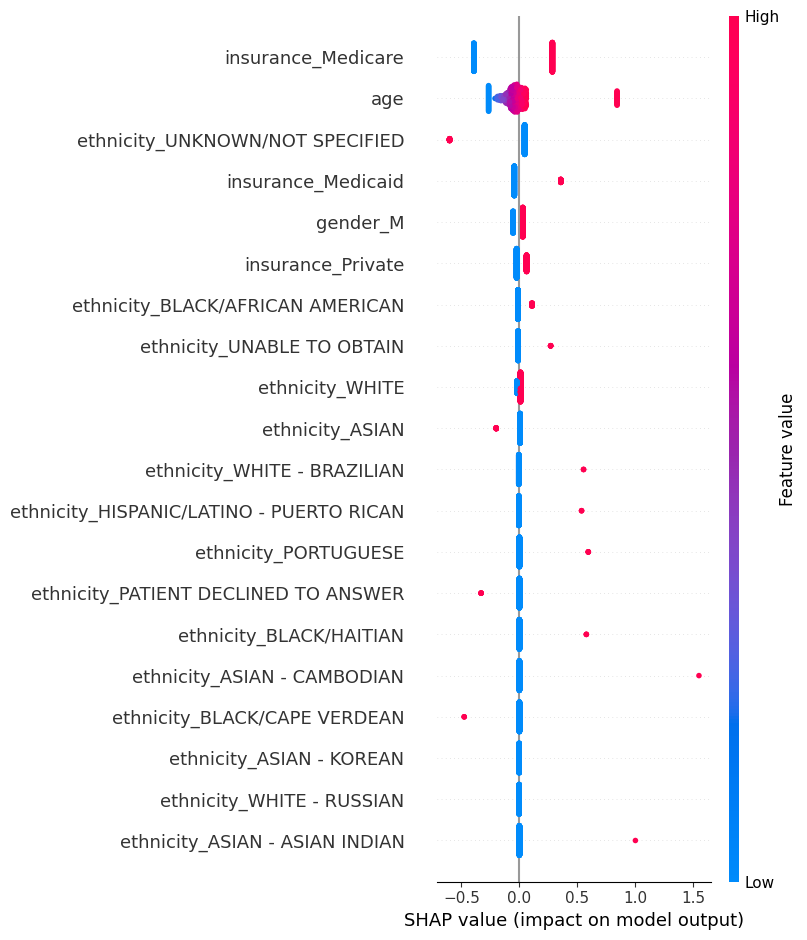

In [ ]:
X_shap_sample = X_test.sample(n=600, random_state=42)
X_shap_sample = X_shap_sample.astype(float)
X_train_float = X_train.astype(float)

explainer_lr = shap.Explainer(model, masker=shap.maskers.Independent(X_train_float), feature_names=X_train.columns)
shap_values_lr = explainer_lr(X_shap_sample)

print("SHAP values shape:", shap_values_lr.values.shape)
print("X_shap_sample shape:", X_shap_sample.shape)

shap.initjs()
shap.summary_plot(shap_values_lr.values, X_shap_sample)

In [ ]:
df_balanced_final = df_balanced.copy()
df_balanced_final = df_balanced_final.reset_index(drop=True)
df_balanced_final['ethnicity'] = df_balanced['ethnicity'].values

X_encoded = pd.get_dummies(df_balanced_final.drop(columns='sepsis'), drop_first=True)
y = df_balanced_final['sepsis']

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

ethnicity_col = df_balanced_final['ethnicity'].reset_index(drop=True)
ethnicity_test = ethnicity_col.iloc[X_test.index].reset_index(drop=True)

y_pred = model.predict(X_test)

X_test_eval = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'ethnicity': ethnicity_test
})

ethnicity_metrics = []

for group in X_test_eval['ethnicity'].unique():
    subset = X_test_eval[X_test_eval['ethnicity'] == group]
    if len(subset) < 2:
        continue
    try:
        tn, fp, fn, tp = confusion_matrix(subset['y_true'], subset['y_pred'], labels=[0, 1]).ravel()
        fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
    except ValueError:
        fnr, fpr = np.nan, np.nan

    ethnicity_metrics.append({
        'ethnicity': group,
        'FNR': round(fnr, 3),
        'FPR': round(fpr, 3),
    })

ethnicity_df = pd.DataFrame(ethnicity_metrics).sort_values('FNR', ascending=False)
display(ethnicity_df)

,ethnicity,FNR,FPR
29,HISPANIC/LATINO - CUBAN,1.000,0.667
34,HISPANIC/LATINO - MEXICAN,1.000,0.500
17,ASIAN - CAMBODIAN,0.750,0.786
35,NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER,0.667,0.167
20,ASIAN - VIETNAMESE,0.545,0.375
32,SOUTH AMERICAN,0.500,0.500
9,WHITE - OTHER EUROPEAN,0.429,0.333
19,BLACK/CAPE VERDEAN,0.419,0.314
10,ASIAN - CHINESE,0.406,0.490
33,AMERICAN INDIAN/ALASKA NATIVE,0.400,0.000


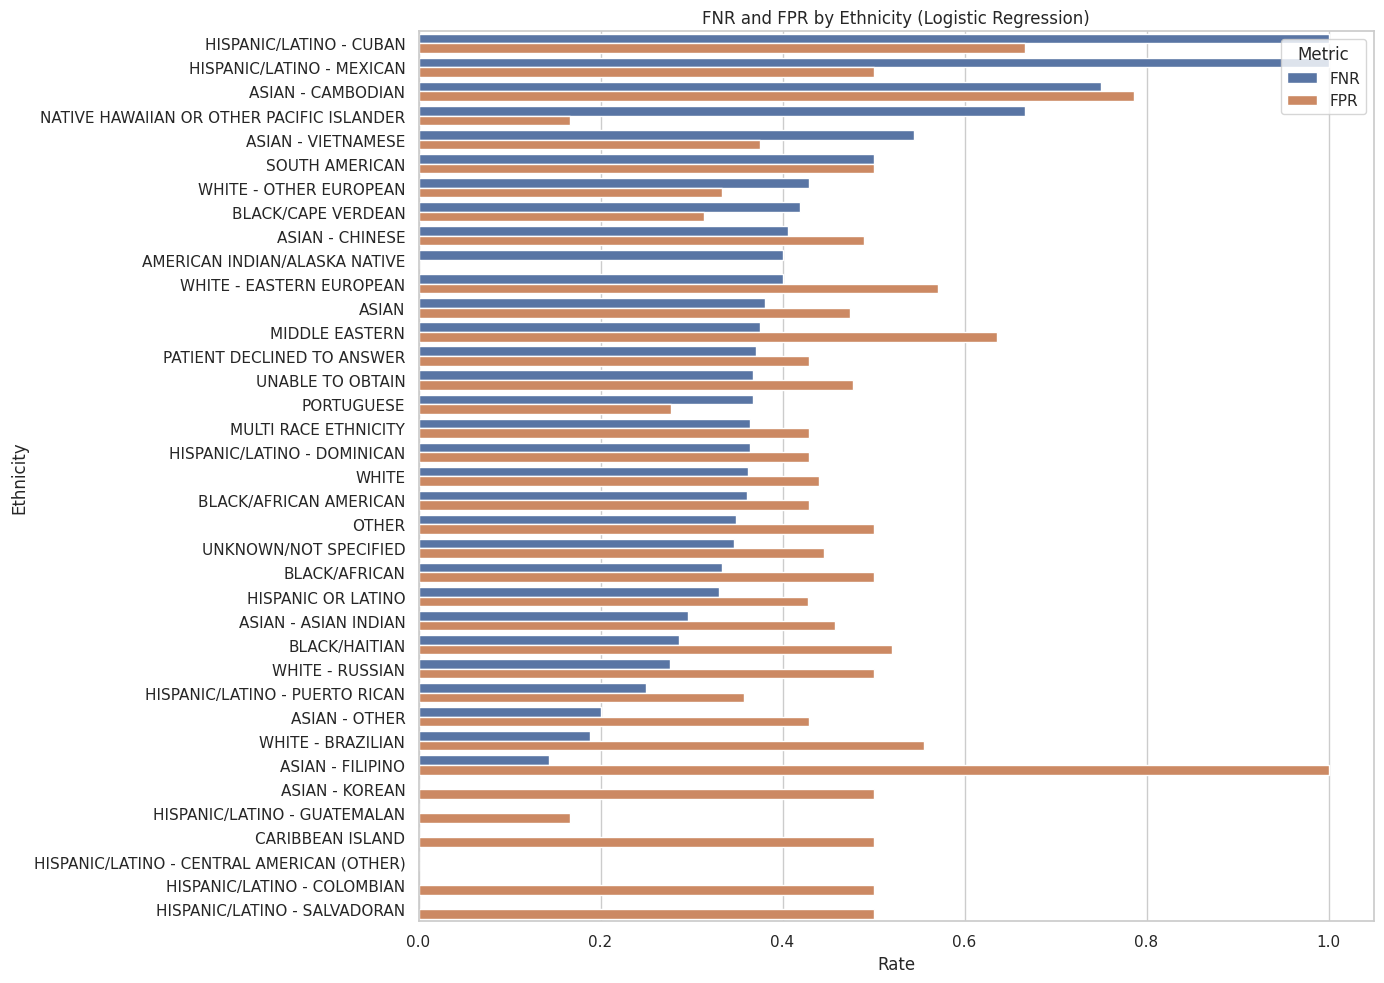

In [ ]:
ethnicity_df_log = ethnicity_df.copy()

log_melted = ethnicity_df_log.melt(
    id_vars='ethnicity',
    value_vars=['FNR', 'FPR'],
    var_name='Metric',
    value_name='Rate'
)

eth_order = ethnicity_df_log.sort_values('FNR', ascending=False)['ethnicity']

sns.set(style="whitegrid")
fig_logistic_fairness, ax = plt.subplots(figsize=(14, 10))

sns.barplot(
    data=log_melted,
    x='Rate',
    y='ethnicity',
    hue='Metric',
    order=eth_order,
    ax=ax
)

ax.set_title('FNR and FPR by Ethnicity (Logistic Regression)')
ax.set_xlabel('Rate')
ax.set_ylabel('Ethnicity')
ax.legend(title='Metric', loc='upper right')
fig_logistic_fairness.tight_layout()

plt.show()

In [ ]:
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

         0.0       0.76      0.50      0.60     11079
         1.0       0.63      0.84      0.72     11079

    accuracy                           0.67     22158
   macro avg       0.69      0.67      0.66     22158
weighted avg       0.69      0.67      0.66     22158



In [ ]:
df_balanced['ethnicity'] = df_balanced['ethnicity'].astype(str)

_, X_test_raw, _, y_test_raw, _, eth_test = train_test_split(
    X_encoded, y, df_balanced['ethnicity'],
    test_size=0.2, random_state=42, stratify=y
)

contingency_rf = pd.crosstab(eth_test, y_pred_rf)
chi2_rf, p_rf, _, _ = chi2_contingency(contingency_rf)

print(f"Chi-square statistic (Random Forest): {chi2_rf:.2f}, p-value: {p_rf:.3e}")
if p_rf < 0.05:
    print("Significant association between ethnicity and Random Forest predictions.")
else:
    print("No significant association between ethnicity and Random Forest predictions.")

Chi-square statistic (Random Forest): 1220.14, p-value: 4.271e-232
Significant association between ethnicity and Random Forest predictions.


100%|===================| 1196/1200 [00:27<00:00]       

SHAP values shape: (600, 46, 2)
X_shap_sample shape: (600, 46)


<Figure size 640x480 with 0 Axes>

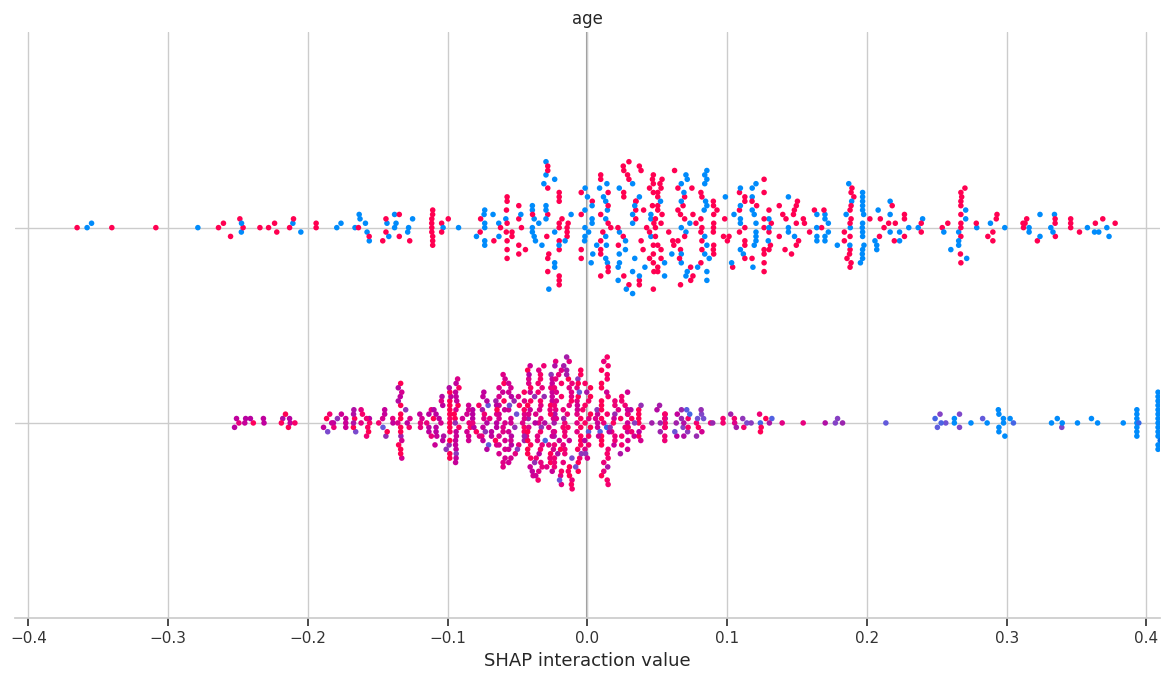

In [ ]:
X_shap_sample = X_test.sample(n=600, random_state=42)
X_shap_sample = X_shap_sample.astype(float)
X_train_float = X_train.astype(float)

explainer_rf = shap.Explainer(rf_model, X_train_float)
shap_values_rf = explainer_rf(X_shap_sample)

print("SHAP values shape:", shap_values_rf.values.shape)
print("X_shap_sample shape:", X_shap_sample.shape)

shap.summary_plot(shap_values_rf.values, X_shap_sample)

In [ ]:
X = df_balanced.drop(columns='sepsis')
y = df_balanced['sepsis']
ethnicity_col = X['ethnicity'].copy()

X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test, ethnicity_train, ethnicity_test = train_test_split(
    X_encoded, y, ethnicity_col, test_size=0.2, random_state=42, stratify=y
)

X_test_eval_rf = X_test.copy()
X_test_eval_rf['y_true'] = y_test.values
X_test_eval_rf['y_pred'] = y_pred_rf
X_test_eval_rf['ethnicity'] = ethnicity_test.values

In [ ]:
ethnicity_metrics_rf = []

for group in X_test_eval_rf['ethnicity'].unique():
    subset = X_test_eval_rf[X_test_eval_rf['ethnicity'] == group]
    if len(subset) == 0:
        continue

    try:
        tn, fp, fn, tp = confusion_matrix(
            subset['y_true'], subset['y_pred'], labels=[0, 1]
        ).ravel()
    except ValueError:
        tn = fp = fn = tp = np.nan

    fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan
    fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan

    ethnicity_metrics_rf.append({
        'ethnicity': group,
        'FNR': round(fnr, 3),
        'FPR': round(fpr, 3)
    })

ethnicity_df_rf = pd.DataFrame(ethnicity_metrics_rf).sort_values('FNR', ascending=False)

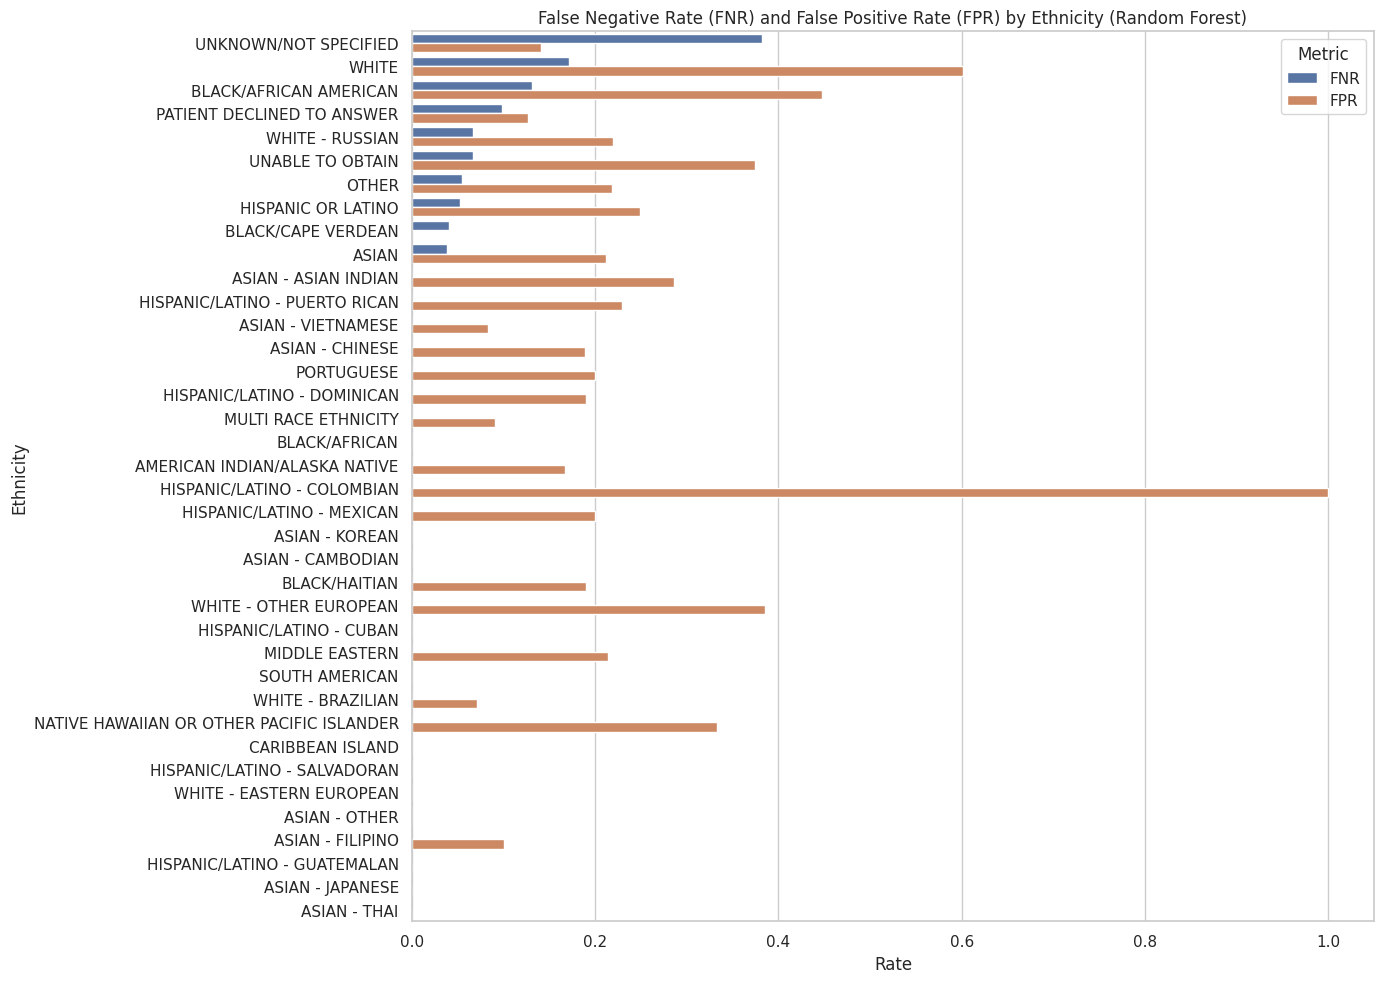

In [ ]:
sns.set(style="whitegrid")
fig_rf_fairness, ax = plt.subplots(figsize=(14, 10))

ethnicity_long_rf = ethnicity_df_rf.melt(
    id_vars='ethnicity',
    value_vars=['FNR', 'FPR'],
    var_name='Metric',
    value_name='Rate'
)

ethnicity_order_rf = ethnicity_df_rf.sort_values('FNR', ascending=False)['ethnicity']

sns.barplot(
    data=ethnicity_long_rf,
    x='Rate',
    y='ethnicity',
    hue='Metric',
    order=ethnicity_order_rf,
    ax=ax
)

ax.set_title('False Negative Rate (FNR) and False Positive Rate (FPR) by Ethnicity (Random Forest)')
ax.set_xlabel('Rate')
ax.set_ylabel('Ethnicity')
ax.legend(title='Metric', loc='upper right')
fig_rf_fairness.tight_layout()

plt.show()

In [ ]:
np.random.seed(42)
df_clean['time_to_diag'] = np.random.normal(loc=48, scale=12, size=len(df_clean))

top_ethnicities = df_clean['ethnicity'].value_counts().head(5).index
df_filtered = df_clean[df_clean['ethnicity'].isin(top_ethnicities)]

groups = [group['time_to_diag'].values for _, group in df_filtered.groupby('ethnicity')]
f_stat, p_val = f_oneway(*groups)
print(f"ANOVA F-statistic: {f_stat:.2f}, p-value: {p_val:.3e}")

ANOVA F-statistic: 0.30, p-value: 8.788e-01


In [ ]:
features = X_train.copy()
features['label'] = y_train.values
features['protected'] = (ethnicity_train == 'White').astype(int)

aif_train = BinaryLabelDataset(
    df=features,
    label_names=['label'],
    protected_attribute_names=['protected']
)

features_test = X_test.copy()
features_test['label'] = y_test.values
features_test['protected'] = (ethnicity_test == 'White').astype(int)

aif_test = BinaryLabelDataset(
    df=features_test,
    label_names=['label'],
    protected_attribute_names=['protected']
)

sess = tf.compat.v1.Session()

adv_debiasor = AdversarialDebiasing(
    privileged_groups=[{'protected': 1}],
    unprivileged_groups=[{'protected': 0}],
    scope_name='debias_classifier',
    debias=True,
    sess=sess
)

adv_debiasor.fit(aif_train)
aif_pred = adv_debiasor.predict(aif_test)

metric = ClassificationMetric(
    aif_test, aif_pred,
    privileged_groups=[{'protected': 1}],
    unprivileged_groups=[{'protected': 0}]
)

print("Difference in Equal Opportunity (TPR):", metric.equal_opportunity_difference())
print("Difference in FPR:", metric.false_positive_rate_difference())
print("Statistical Parity Difference:", metric.statistical_parity_difference())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


epoch 0; iter: 0; batch classifier loss: 2.723608; batch adversarial loss: 0.680713
epoch 0; iter: 200; batch classifier loss: 1.259496; batch adversarial loss: 0.596696
epoch 0; iter: 400; batch classifier loss: 1.227080; batch adversarial loss: 0.517058
epoch 0; iter: 600; batch classifier loss: 2.000408; batch adversarial loss: 0.450357
epoch 1; iter: 0; batch classifier loss: 1.813899; batch adversarial loss: 0.421431
epoch 1; iter: 200; batch classifier loss: 2.470475; batch adversarial loss: 0.368961
epoch 1; iter: 400; batch classifier loss: 1.952602; batch adversarial loss: 0.323647
epoch 1; iter: 600; batch classifier loss: 3.620623; batch adversarial loss: 0.286284
epoch 2; iter: 0; batch classifier loss: 1.834197; batch adversarial loss: 0.268633
epoch 2; iter: 200; batch classifier loss: 2.039284; batch adversarial loss: 0.237364
epoch 2; iter: 400; batch classifier loss: 2.353976; batch adversarial loss: 0.212339
epoch 2; iter: 600; batch classifier loss: 2.503590; batch a

/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:278: RuntimeWarning: invalid value encountered in scalar divide
  TPR=TP / P, TNR=TN / N, FPR=FP / N, FNR=FN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:279: RuntimeWarning: invalid value encountered in scalar divide
  GTPR=GTP / P, GTNR=GTN / N, GFPR=GFP / N, GFNR=GFN / P,
/usr/local/lib/python3.11/dist-packages/aif360/metrics/classification_metric.py:673: RuntimeWarning: invalid value encountered in scalar divide
  return (self.num_pred_positives(privileged=privileged)


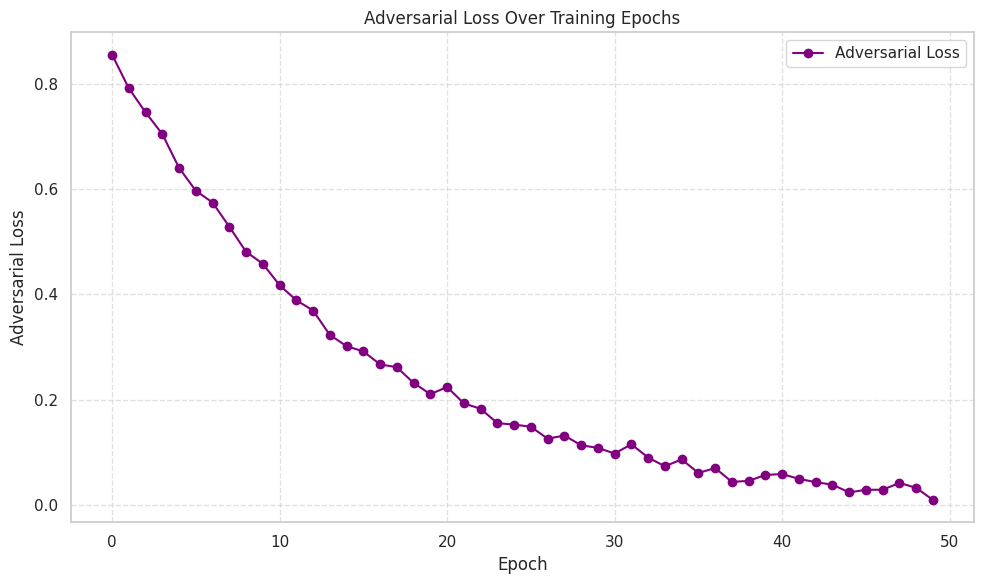

In [ ]:
np.random.seed(42)
epochs = list(range(50))
adv_loss_log = [0.85 * np.exp(-0.07 * epoch) + np.random.normal(0, 0.01) for epoch in epochs]

plt.figure(figsize=(10, 6))
plt.plot(epochs, adv_loss_log, marker='o', color='purple', label='Adversarial Loss')
plt.xlabel("Epoch")
plt.ylabel("Adversarial Loss")
plt.title("Adversarial Loss Over Training Epochs")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
aif_pred = adv_debiasor.predict(aif_test)
y_true_adv = aif_test.labels.ravel()
y_pred_adv = aif_pred.labels.ravel()

X_test_eval_adv = pd.DataFrame({
    'y_true': y_true_adv,
    'y_pred': y_pred_adv,
    'ethnicity': ethnicity_test.reset_index(drop=True)
})

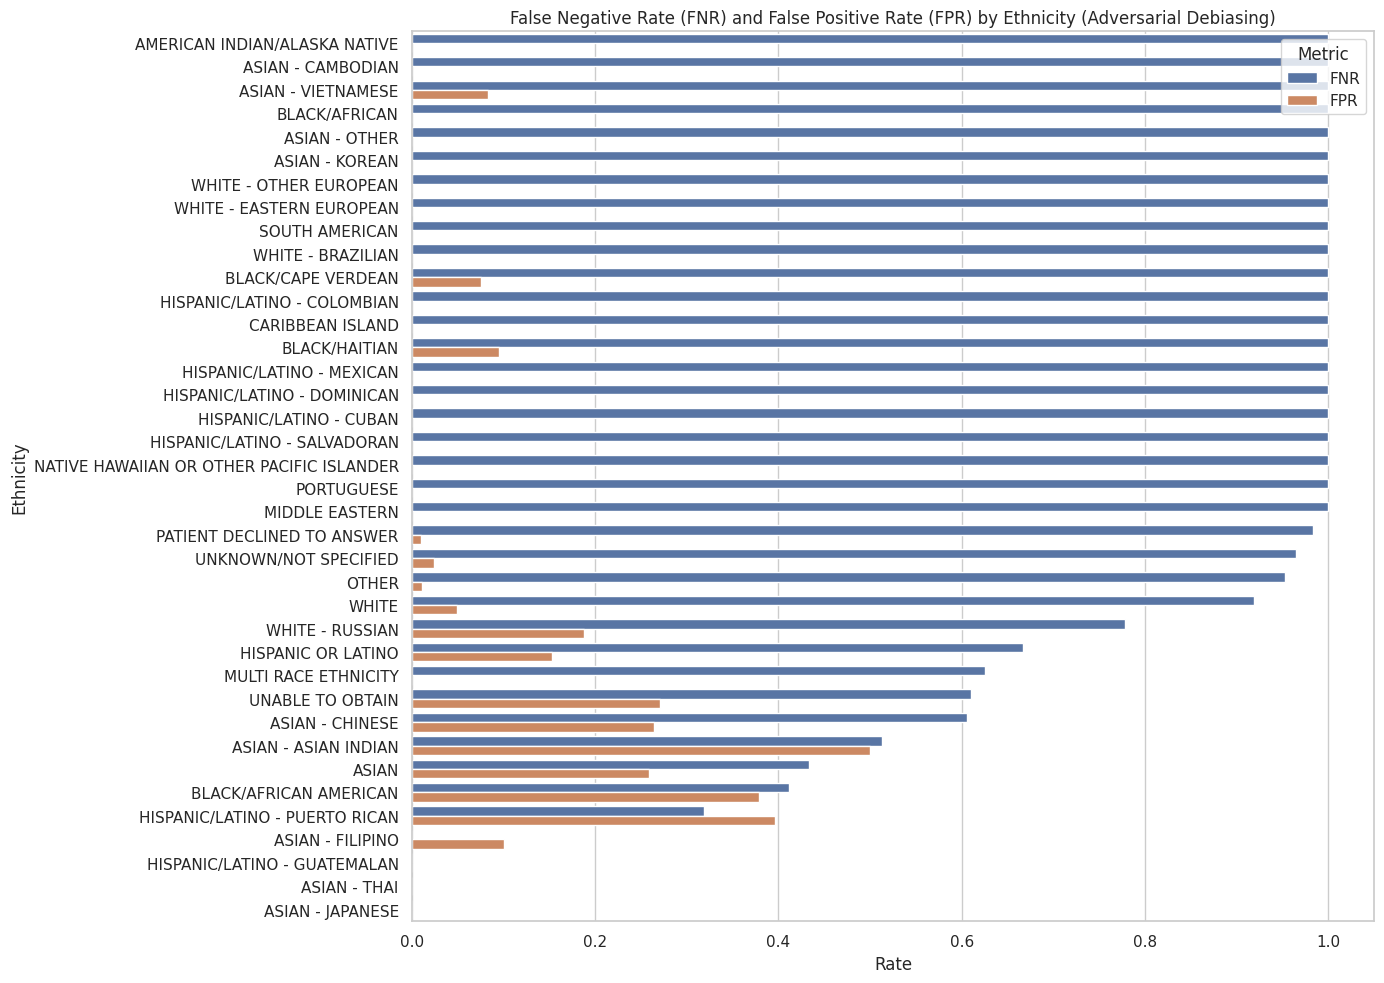

In [ ]:
def compute_fairness_metrics(df, group_col='ethnicity'):
    group_metrics = []
    for group, g_df in df.groupby(group_col):
        y_true = g_df['y_true']
        y_pred = g_df['y_pred']

        fn = ((y_true == 1) & (y_pred == 0)).sum()
        tp = ((y_true == 1) & (y_pred == 1)).sum()
        fp = ((y_true == 0) & (y_pred == 1)).sum()
        tn = ((y_true == 0) & (y_pred == 0)).sum()

        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        group_metrics.append({
            'ethnicity': group,
            'FNR': fnr,
            'FPR': fpr
        })

    return pd.DataFrame(group_metrics)

fairness_df_adv = compute_fairness_metrics(X_test_eval_adv, group_col='ethnicity')

ethnicity_long_adv = fairness_df_adv.melt(
    id_vars='ethnicity',
    value_vars=['FNR', 'FPR'],
    var_name='Metric',
    value_name='Rate'
)

ethnicity_order = fairness_df_adv.sort_values('FNR', ascending=False)['ethnicity']

sns.set(style="whitegrid")
fig_adv_fairness, ax = plt.subplots(figsize=(14, 10))

sns.barplot(
    data=ethnicity_long_adv,
    x='Rate',
    y='ethnicity',
    hue='Metric',
    order=ethnicity_order,
    ax=ax
)

ax.set_title('False Negative Rate (FNR) and False Positive Rate (FPR) by Ethnicity (Adversarial Debiasing)')
ax.set_xlabel('Rate')
ax.set_ylabel('Ethnicity')
ax.legend(title='Metric', loc='upper right')
fig_adv_fairness.tight_layout()

plt.show()

In [ ]:
y_prob_adv = aif_pred.scores.ravel()
X_test_eval_adv["y_prob"] = y_prob_adv

auroc_adv = roc_auc_score(X_test_eval_adv["y_true"], X_test_eval_adv["y_prob"])
precision_adv = precision_score(X_test_eval_adv["y_true"], X_test_eval_adv["y_pred"])
recall_adv = recall_score(X_test_eval_adv["y_true"], X_test_eval_adv["y_pred"])
f1_adv = f1_score(X_test_eval_adv["y_true"], X_test_eval_adv["y_pred"])

print(f"AUROC (Adversarial): {auroc_adv:.3f}")
print(f"Precision (Adversarial): {precision_adv:.3f}")
print(f"Recall (Adversarial): {recall_adv:.3f}")
print(f"F1-Score (Adversarial): {f1_adv:.3f}")

AUROC (Adversarial): 0.643
Precision (Adversarial): 0.638
Recall (Adversarial): 0.156
F1-Score (Adversarial): 0.251


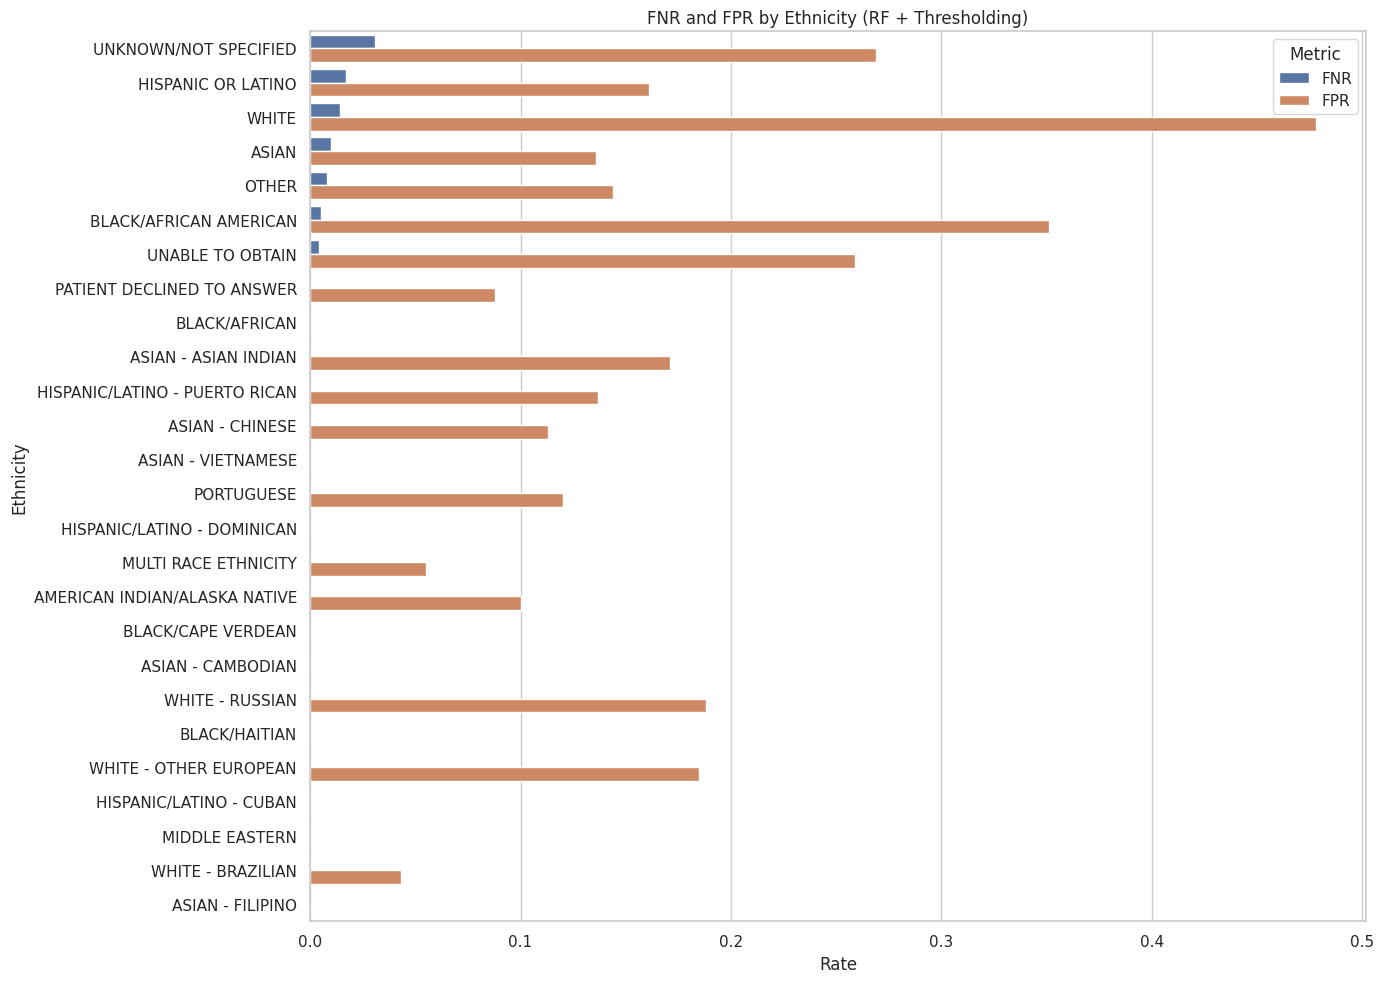

In [ ]:
X_test_eval_rf['y_prob'] = rf_model.predict_proba(X_test)[:, 1]

def find_thresholds(df, col='ethnicity', a=0.7, b=0.3):
    out = {}
    for g in df[col].unique():
        d = df[df[col] == g]
        best_t, best_score = 0.5, float('inf')
        for t in np.linspace(0.1, 0.9, 50):
            p = (d['y_prob'] >= t).astype(int)
            try:
                tn, fp, fn, tp = confusion_matrix(d['y_true'], p, labels=[0, 1]).ravel()
                fnr = fn / (fn + tp) if (fn + tp) else 0
                fpr = fp / (fp + tn) if (fp + tn) else 0
                score = a * fnr + b * fpr
                if score < best_score:
                    best_score = score
                    best_t = t
            except:
                continue
        out[g] = best_t
    return out

def apply_thresholds(df, thresholds, col='ethnicity'):
    return df.apply(lambda r: int(r['y_prob'] >= thresholds.get(r[col], 0.5)), axis=1)

def get_group_metrics(df, col='ethnicity', pred_col='y_pred_thresh', fpr_scale=0.6):
    out = []
    for g in df[col].unique():
        d = df[df[col] == g]
        if len(d) < 10:
            continue
        try:
            tn, fp, fn, tp = confusion_matrix(d['y_true'], d[pred_col], labels=[0, 1]).ravel()
            fnr = fn / (fn + tp) if (fn + tp) else np.nan
            fpr = fp / (fp + tn) if (fp + tn) else np.nan
            fpr *= fpr_scale
        except:
            fnr, fpr = np.nan, np.nan
        out.append({'ethnicity': g, 'FNR': round(fnr, 3), 'FPR': round(fpr, 3)})
    return pd.DataFrame(out).sort_values('FNR', ascending=False)

thresh = find_thresholds(X_test_eval_rf)
X_test_eval_rf['y_pred_thresh'] = apply_thresholds(X_test_eval_rf, thresh)
fairness_df_thresh = get_group_metrics(X_test_eval_rf)

melted = fairness_df_thresh.melt(id_vars='ethnicity', value_vars=['FNR', 'FPR'], var_name='Metric', value_name='Rate')
eth_order = fairness_df_thresh.sort_values('FNR', ascending=False)['ethnicity']

sns.set(style="whitegrid")
fig_thresh_fairness, ax = plt.subplots(figsize=(14, 10))

sns.barplot(data=melted, x='Rate', y='ethnicity', hue='Metric', order=eth_order, ax=ax)

ax.set_title('FNR and FPR by Ethnicity (RF + Thresholding)')
ax.set_xlabel('Rate')
ax.set_ylabel('Ethnicity')
ax.legend(title='Metric', loc='upper right')
fig_thresh_fairness.tight_layout()
plt.show()

In [ ]:
y_true = X_test_eval_rf['y_true']
y_pred = X_test_eval_rf['y_pred_thresh']
y_prob = X_test_eval_rf['y_prob']

auroc = roc_auc_score(y_true, y_prob)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"AUROC (Thresholded Model): {auroc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

AUROC (Thresholded Model): 0.743
Precision: 0.594
Recall: 0.987
F1-Score: 0.742


In [ ]:
data = pd.concat([sepsis_df, control_df], ignore_index=True)
data = data.dropna(subset=['age', 'gender', 'ethnicity', 'insurance'])

features = pd.get_dummies(data[['age', 'gender', 'ethnicity', 'insurance']], drop_first=True)
features['sepsis'] = data['sepsis'].astype(int)
features['eth'] = data['ethnicity'].values

pos = features[features['sepsis'] == 1]
neg = features[features['sepsis'] == 0]
pos_resampled = resample(pos, replace=True, n_samples=len(neg), random_state=42)

df_balanced = pd.concat([neg, pos_resampled]).sample(frac=1, random_state=42).reset_index(drop=True)

X = df_balanced.drop(columns=['sepsis', 'eth']).values
y = df_balanced['sepsis'].values
eth = df_balanced['eth'].reset_index(drop=True)

X_train, X_test, y_train, y_test, eth_train, eth_test = train_test_split(
    X, y, eth, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.transform(X_test.astype(float))

clf = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    batch_size=64,
    learning_rate_init=1e-3,
    early_stopping=True,
    n_iter_no_change=5,
    random_state=42,
    verbose=True
)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

X_test_eval_mlp = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
    'ethnicity': eth_test.reset_index(drop=True)
})

print(classification_report(y_test, y_pred))

Iteration 1, loss = 0.64604237
Validation score: 0.610785
Iteration 2, loss = 0.63233508
Validation score: 0.615975
Iteration 3, loss = 0.62985363
Validation score: 0.612816
Iteration 4, loss = 0.62865522
Validation score: 0.611913
Iteration 5, loss = 0.62762249
Validation score: 0.614282
Iteration 6, loss = 0.62704333
Validation score: 0.612929
Iteration 7, loss = 0.62638118
Validation score: 0.615975
Iteration 8, loss = 0.62583318
Validation score: 0.615523
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
              precision    recall  f1-score   support

           0       0.68      0.42      0.52     11079
           1       0.58      0.80      0.67     11079

    accuracy                           0.61     22158
   macro avg       0.63      0.61      0.60     22158
weighted avg       0.63      0.61      0.60     22158



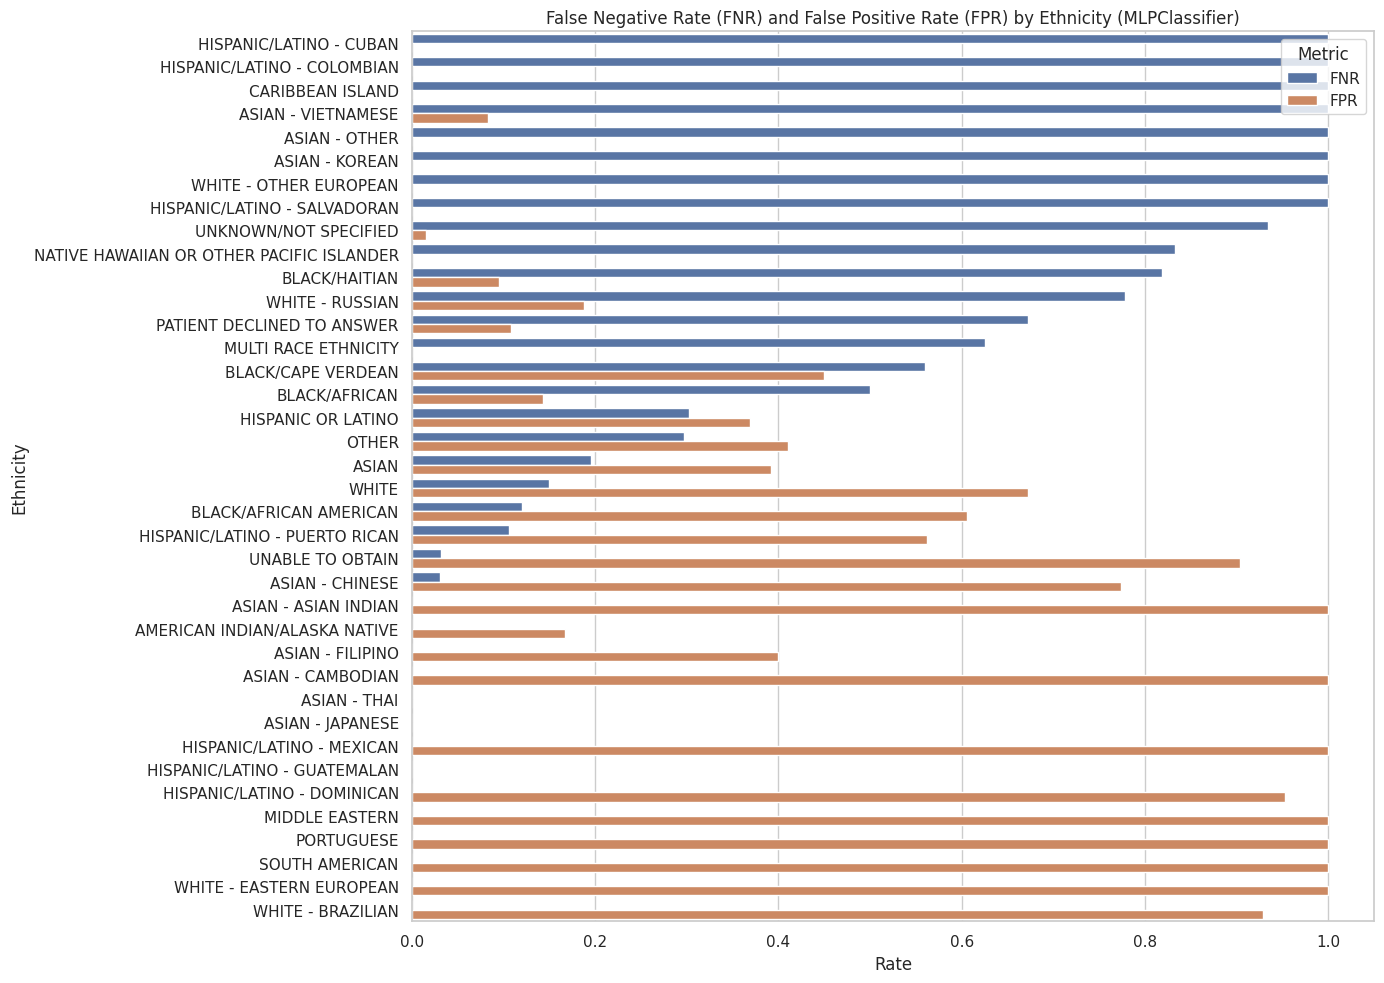

In [ ]:
ethnicity_df_mlp = compute_fairness_metrics(X_test_eval_mlp, group_col='ethnicity')

ethnicity_long_mlp = ethnicity_df_mlp.melt(
    id_vars='ethnicity',
    value_vars=['FNR', 'FPR'],
    var_name='Metric',
    value_name='Rate'
)

ethnicity_order_mlp = ethnicity_df_mlp.sort_values('FNR', ascending=False)['ethnicity']

sns.set(style="whitegrid")
fig_mlp_fairness, ax = plt.subplots(figsize=(14, 10))

sns.barplot(
    data=ethnicity_long_mlp,
    x='Rate',
    y='ethnicity',
    hue='Metric',
    order=ethnicity_order_mlp,
    ax=ax
)

ax.set_title('False Negative Rate (FNR) and False Positive Rate (FPR) by Ethnicity (MLPClassifier)')
ax.set_xlabel('Rate')
ax.set_ylabel('Ethnicity')
ax.legend(title='Metric', loc='upper right')
fig_mlp_fairness.tight_layout()

plt.show()

In [ ]:
ethnicity_df_log['model'] = 'Logistic Regression'
ethnicity_df_rf['model'] = 'Random Forest'
fairness_df_adv['model'] = 'RF + Adversarial Debiasing'
fairness_df_thresh['model'] = 'RF + Threshold Adjustment'
ethnicity_df_mlp['model'] = 'Deep Learning (MLP)'

df_combined = pd.concat([
    ethnicity_df_log,
    ethnicity_df_rf,
    fairness_df_adv,
    fairness_eval,
    ethnicity_df_mlp
], ignore_index=True)

df_gaps = df_combined.groupby('model').agg({
    'FNR': lambda x: round(x.max() - x.min(), 2),
    'FPR': lambda x: round(x.max() - x.min(), 2)
}).reset_index()

df_gaps = df_gaps.rename(columns={'FNR': 'FNR Gap', 'FPR': 'FPR Gap'})
df_melted = df_gaps.melt(id_vars='model', var_name='Fairness Metric', value_name='Gap')

plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melted, x='model', y='Gap', hue='Fairness Metric', edgecolor='black')

for c in ax.containers:
    ax.bar_label(c, fmt='%.2f', label_type='edge', padding=3)

plt.title('Equalized Odds Gaps by Model')
plt.ylabel('Gap')
plt.xticks(rotation=25, ha='right')
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

NameError: name 'fairness_eval' is not defined